<a href="https://colab.research.google.com/github/sfwtopoulos/stocks/blob/master/Stocks_seq_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import math
import warnings
import numpy as np
import time

import pandas_datareader as pdr
#%tensorflow_version 2.x
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 1.x
import tensorflow as tf
import keras


from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [22]:
print(keras.__version__)
print(tf.__version__)
#print(tensorflow.compat.v2.__version__)

2.2.5
1.15.0


In [0]:
#Data import from git repo
url = 'https://raw.githubusercontent.com/sfwtopoulos/stocks/master/stocks_dataset/combined.csv'
#df1 = pd.read_csv(url, error_bad_lines=False)
dfstocks = pd.read_csv(url, sep=',')

In [24]:
#fix column names
dfstocks=dfstocks.rename({' AAPL':'Company', ' Close/Last':'Close', ' Volume':'Volume', ' Open':'Open', ' High':'High', ' Low':'Low'}, axis=1);
for col in dfstocks.columns: 
    print(col) 

Date
Close
Volume
Open
High
Low
Company


In [0]:
#drop $sign from values
dfstocks.Close=dfstocks['Close'].astype(str)
dfstocks.Close=dfstocks.Close.apply(lambda x: x.replace('$',''))
dfstocks.Open=dfstocks['Open'].astype(str)
dfstocks.Open=dfstocks.Open.apply(lambda x: x.replace('$',''))
dfstocks.High=dfstocks['High'].astype(str)
dfstocks.High=dfstocks.High.apply(lambda x: x.replace('$',''))
dfstocks.Low=dfstocks['Low'].astype(str)
dfstocks.Low=dfstocks.Low.apply(lambda x: x.replace('$',''))

In [26]:
#drop rows containing nan or header from the csv files
dfstocks=dfstocks[~dfstocks.Low.str.contains("nan")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("Low")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("N/A")]
dfstocks=dfstocks[~dfstocks.Volume.str.contains("N/A")]
dfstocks.reset_index(drop=True, inplace=True)
dfstocks.Date.count()

229269

In [27]:
#sort dataframe based on date and Company Name
dfstocks = dfstocks.sort_values(['Date', 'Company'])
dfstocks.head(100)

,Date,Close,Volume,Open,High,Low,Company
1761,01/02/2013,78.4328,139906732,79.1171,79.2857,77.3757,AAPL
4248,01/02/2013,35.12,13767660,34.92,35.4,34.1,ABBV
6025,01/02/2013,32.05,20266410,32.3,32.45,31.64,ABT
8512,01/02/2013,69.06,4039095,67.59,69.06,67.55,ACN
10999,01/02/2013,38.34,6483720,37.92,38.73,37.92,ADBE
...,...,...,...,...,...,...,...
10747,01/02/2014,59.29,2745895,59.06,59.53,58.94,ADBE
13234,01/02/2014,168.05,1268722,167.33,170.71,166.5937,AGN
15721,01/02/2014,50.71,9196092,50.81,51.3,50.47,AIG
18208,01/02/2014,53.55,1909106,54.09,54.45,53.5,ALL


In [28]:
#Converting Datatypes
dfstocks.Date=pd.to_datetime(dfstocks.Date)
dfstocks.Close=pd.to_numeric(dfstocks.Close)
dfstocks.Volume=pd.to_numeric(dfstocks.Volume)
dfstocks.Open=pd.to_numeric(dfstocks.Open)
dfstocks.High=pd.to_numeric(dfstocks.High)
dfstocks.Low=pd.to_numeric(dfstocks.Low)
dfstocks.dtypes

Date       datetime64[ns]
Close             float64
Volume              int64
Open              float64
High              float64
Low               float64
Company            object
dtype: object

In [29]:
#dfstocks[dfstocks['Company'].str.contains("AMZN")]
sub_split=dfstocks[dfstocks['Company'].str.contains("ABBV")]
sub_split.isnull().values.any()
sub_split.isna().values.any()
sub_split = sub_split.sort_values(['Date'])
sub_split.reset_index(drop=True, inplace=True)
sub_split.shape[0]

1777

In [30]:
sub_split

,Date,Close,Volume,Open,High,Low,Company
0,2012-12-10,35.00,749378,37.00,37.00,34.91,ABBV
1,2012-12-11,35.32,1472086,35.05,35.69,34.95,ABBV
2,2012-12-12,33.36,2530442,35.25,35.25,33.09,ABBV
3,2012-12-13,33.80,4253303,33.50,34.24,32.61,ABBV
4,2012-12-14,33.00,4006673,33.90,34.08,32.65,ABBV
...,...,...,...,...,...,...,...
1772,2019-12-24,89.85,1798844,90.40,90.40,89.43,ABBV
1773,2019-12-26,89.83,4066926,90.20,90.72,89.45,ABBV
1774,2019-12-27,89.20,4087837,89.98,90.28,88.83,ABBV
1775,2019-12-30,88.52,7016346,89.22,89.73,88.16,ABBV


In [0]:
# prepare training and testing data sets for LSTM based sequence modeling
#def dimitris_function(time_series, scaling=True,split_ratio=0.9):
def dimitris_function(time_series,split_ratio=0.9):

    series1 = pd.Series(time_series[time_series.columns[0]])
    series2 = pd.Series(time_series[time_series.columns[1]])

    values1 = series1.values
    values1 = values1.reshape((len(values1), 1))
    values2 = series2.values
    values2 = values2.reshape((len(values2), 1))

    scaler1 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled1"] = scaler1.fit_transform(values1)
    scaler2 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled2"]= scaler2.fit_transform(values2)


    time_series = time_series[["scaled1","scaled2"]].values

        
    split_ratio = int(len(time_series) * split_ratio)

    train = time_series[0:split_ratio]
    test = time_series[split_ratio:len(time_series)]
    
    # return train,test,scaler1,scaler2
    return train,test,scaler2


In [0]:
def get_seq_model(hidden_units=4,input_shape=(1,1)):
    # create and fit the LSTM network
    model = Sequential()
    # samples*timesteps*features
    # https://keras.io/getting-started/sequential-model-guide/
    #relu_advanced=keras.activations.relu(x,)
    model.add(LSTM(input_shape=input_shape,
                   units = hidden_units,  
   #                activation='relu',
                   return_sequences=True
    ))

    # readout layer. TimeDistributedDense uses the same weights for all
    # time steps.
    # model.add(TimeDistributed(Dense(1))) #number of inputs in the 1st layer
    model.add(TimeDistributed(Dense(2)))   
    start = time.time()
    
    model.compile(loss="mse", optimizer="rmsprop")

    print("> Compilation Time : ", time.time() - start)
    print(model.summary())

    return model

In [0]:
# print(type(sub_split.Close))
sub_split_date=sub_split[['Date']]
sub_split=sub_split[['Volume', 'Close']]
#sub_split.columns[1]

In [34]:
# split train and test datasets
train,test,scaler_Close = dimitris_function(sub_split,split_ratio=0.7)

#train
print(len(train))
print(train.shape[0])
print(train.shape)
print(test.shape)
print(train)

1243
1243
(1243, 2)
(534, 2)
[[0.00378592 0.02217049]
 [0.00969972 0.02571777]
 [0.01836008 0.00399069]
 ...
 [0.04813477 0.69205188]
 [0.03067735 0.68861545]
 [0.03625402 0.68451391]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
#We use numpy to reshape our time series into 3D tensors.
train = np.reshape(train,(1,train.shape[0],2))
test = np.reshape(test,(1,test.shape[0],2))

train_x = train[:,:-1,:]
train_y = train[:,1:,:]

test_x = test[:,:-1,:]
test_y = test[:,1:,:]

print("Data Split Complete")

print("train_x shape={}".format(train_x.shape))
print("train_y shape={}".format(train_y.shape))
print("test_x shape={}".format(test_x.shape))
print("test_y shape={}".format(test_y.shape))

Data Split Complete
train_x shape=(1, 1242, 2)
train_y shape=(1, 1242, 2)
test_x shape=(1, 533, 2)
test_y shape=(1, 533, 2)


In [36]:
# build RNN model
seq_lstm_model=None
try:
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],2))
except:
    print("Model Build Failed. Trying Again")
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],2))

> Compilation Time :  0.020964860916137695
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1242, 4)           112       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1242, 2)           10        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
train_y

array([[[0.00969972, 0.02571777],
        [0.01836008, 0.00399069],
        [0.03245797, 0.0088682 ],
        ...,
        [0.04813477, 0.69205188],
        [0.03067735, 0.68861545],
        [0.03625402, 0.68451391]]])

In [38]:
# train the model
seq_lstm_model.fit(train_x, train_y,
                #epochs=20, batch_size=1,
                epochs=250, batch_size=1,
                verbose=1)
print("Model Fit Complete")

Epoch 1/250
1/1 [==============================] - 1s 1s/step - loss: 0.0364
Epoch 2/250
1/1 [==============================] - 1s 677ms/step - loss: 0.0335
Epoch 3/250
1/1 [==============================] - 1s 720ms/step - loss: 0.0315
Epoch 4/250
1/1 [==============================] - 1s 678ms/step - loss: 0.0299
Epoch 5/250
1/1 [==============================] - 1s 665ms/step - loss: 0.0286
Epoch 6/250
1/1 [==============================] - 1s 670ms/step - loss: 0.0274
Epoch 7/250
1/1 [==============================] - 1s 681ms/step - loss: 0.0263
Epoch 8/250
1/1 [==============================] - 1s 651ms/step - loss: 0.0252
Epoch 9/250
1/1 [==============================] - 1s 668ms/step - loss: 0.0243
Epoch 10/250
1/1 [==============================] - 1s 645ms/step - loss: 0.0234
Epoch 11/250
1/1 [==============================] - 1s 644ms/step - loss: 0.0225
Epoch 12/250
1/1 [==============================] - 1s 670ms/step - loss: 0.0217
Epoch 13/250
1/1 [======================

In [39]:
# train fit performance
trainPredict = seq_lstm_model.predict(train_x)
trainScore = math.sqrt(mean_squared_error(train_y[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.04 RMSE


In [40]:
trainPredict

array([[[0.02194942, 0.02989032],
        [0.02744323, 0.03029384],
        [0.03179725, 0.02872419],
        ...,
        [0.0459342 , 0.6777052 ],
        [0.0450471 , 0.6799429 ],
        [0.04449835, 0.68184537]]], dtype=float32)

In [0]:
# Pad input sequence
testPredict = pad_sequences(test_x,maxlen=train_x.shape[1],padding='post',dtype='float64')

In [42]:
# forecast values
testPredict = seq_lstm_model.predict(testPredict)
testPredict

array([[[ 0.03223204,  0.09129144],
        [ 0.04433065,  0.15526147],
        [ 0.05209483,  0.21580061],
        ...,
        [ 0.05116428, -0.00596672],
        [ 0.05116428, -0.00596672],
        [ 0.05116428, -0.00596672]]], dtype=float32)

In [0]:
#Drop all other variables except Close Price Output
testPredict=np.delete(testPredict, 0, 2)
trainPredict=np.delete(trainPredict, 0, 2)

In [44]:
trainPredict


array([[[0.02989032],
        [0.03029384],
        [0.02872419],
        ...,
        [0.6777052 ],
        [0.6799429 ],
        [0.68184537]]], dtype=float32)

In [45]:
type(testPredict)

numpy.ndarray

In [0]:
# # inverse transformation of the Close Price
trainPredict = scaler_Close.inverse_transform(trainPredict.\
                                        reshape(-1,1))
testPredict = scaler_Close.inverse_transform(testPredict.\
                                       reshape(-1,1))

In [47]:
trainPredict

array([[35.696407],
       [35.732807],
       [35.59121 ],
       ...,
       [94.13579 ],
       [94.33765 ],
       [94.50927 ]], dtype=float32)

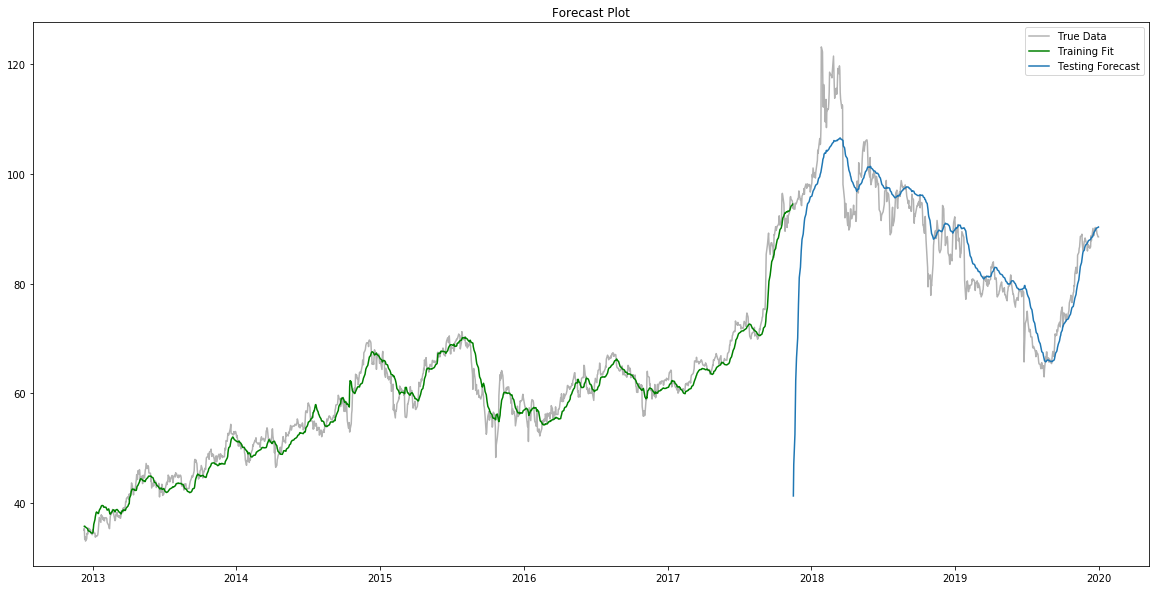

In [49]:
# plot the true and forecasted values
split_ratio = len(trainPredict)+1

plt.plot(sub_split_date.Date,
          sub_split.Close.values,c='black',
          alpha=0.3,label='True Data')

plt.plot(sub_split_date.Date[1:split_ratio],
          trainPredict,label='Training Fit',c='g')

plt.plot(sub_split_date.Date[split_ratio+1:],
          testPredict[:test_x.shape[1]],label='Testing Forecast')
plt.title('Forecast Plot')
plt.legend()
#plt.show()
plt.rcParams["figure.figsize"] = (20,10)
plt.show()